In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import pandas as pd
#from ray import tune
#from ray.tune import grid_search, uniform
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import argparse
import scipy.io
import os


In [3]:
#file = 'Porsche/3L_ANPC_scaled_more_properties.mat'           #rmse:0.0163, mae:0.0041 ,r2: 0.974003 at lr:0.003,drop:0.05, 2048neurons, 3layers, 10 epochs
file = 'Porsche/3L_NPC_scaled_32_25_synthetic.mat'  #rmse:0.0279, mae:0.0087 ,r2:0.925 at lr:0.003,drop:0.05, 2048neurons, 3layers, 10 epochs
mat_data = scipy.io.loadmat(file)
topology = '3L_NPC'
print(topology)
#Get scaled input and scaled output data
#Min max S
input = mat_data.get('input')
output = mat_data.get('output')
input_scaled = mat_data.get('input_scaled')
output_scaled = mat_data.get('output_scaled')

output_scaled = output_scaled[:,0:3]
print(input_scaled.shape)
print(output_scaled.shape)
print(input_scaled)
print(output_scaled)

3L_NPC
(1569590, 32)
(1569590, 3)
[[0.89583333 0.52       0.60880196 ... 0.18458533 0.42683212 0.49132693]
 [0.54166667 0.2        0.28850856 ... 0.18458533 0.42683212 0.49132693]
 [0.04166667 0.08       0.94376528 ... 0.18458533 0.42683212 0.49132693]
 ...
 [0.75       0.88       0.06601467 ... 0.72942076 0.00398033 0.        ]
 [1.         0.48       0.         ... 0.72942076 0.00398033 0.        ]
 [0.85416667 0.72       0.3398533  ... 0.72942076 0.00398033 0.        ]]
[[0.03939392 0.89113781 0.25817059]
 [0.09662513 0.89517354 0.29509413]
 [0.01386264 0.98650113 0.13676103]
 ...
 [0.77462516 0.88474254 0.49833065]
 [0.8242149  0.77610517 0.35721428]
 [0.46327874 0.88544252 0.33323166]]


In [4]:

class MLP(nn.Module):
  def __init__(self, input_size, output_size, num_layers, num_neurons, dropout =   0.0008):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.activation_fn = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        for i in range(num_layers):
          if i == 0:
            self.layers.append(nn.Linear(input_size, num_neurons))
            self.bn_layers.append(nn.BatchNorm1d(num_neurons))
          else:
            self.layers.append(nn.Linear(num_neurons // (2**(i-1)), num_neurons // (2**i)))
            self.bn_layers.append(nn.BatchNorm1d(num_neurons // (2**i)))
            #self.layers.append(nn.Linear(num_neurons, num_neurons))
            #self.bn_layers.append(nn.BatchNorm1d(num_neurons))

        # Try Relu also here after going through hyperparamter tuning
        self.output_layer = nn.Linear(num_neurons // (2**(num_layers-1)), output_size)
        #self.output_layer = nn.Linear(num_neurons, output_size)
        self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      for i in range(self.num_layers):
        x = self.layers[i](x)
        x = self.bn_layers[i](x)
        x = self.dropout(x)
        x = self.activation_fn(x)

      x = self.output_layer(x)
      x = self.sigmoid(x)
      return x


In [5]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_data = torch.Tensor(input_scaled)
output_data = torch.Tensor(output_scaled)
#print(input_data)


# Split the data into training, validation, and testing sets
#test_size = 0.2 ist 80% Training set
train_data, test_data, train_target, test_target = train_test_split(
    input_data, output_data, test_size=0.8, random_state=42
)

#test_size hier auf 0.5 heißt die übrigen 20% nochmal in 10% für val und 10% für test
val_data, test_data, val_target, test_target = train_test_split(
    test_data, test_target, test_size=0.5, random_state=42
)
#data = pd.DataFrame(train_data.numpy())
#print(len(data.iloc[:,7]))
#unique_values = data.iloc[:,7].unique()
#print(len(unique_values))
# Create data loaders
train_dataset = TensorDataset(train_data, train_target)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True) #256 mae:, rmse:, r2:   32 mae:, rmse:, r2:
val_dataset = TensorDataset(val_data, val_target)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataset = TensorDataset(test_data, test_target)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

cpu


In [6]:
# Define the dimensions of your input, hidden, and output layers
num_layers = 8
num_neurons = 4096
input_size = input_data.shape[1]
output_size = output_data.shape[1]


print(input_data.shape[0])
# Create an instance of the MLP model
model = MLP(input_size, output_size, num_layers, num_neurons).to(device)


#Define inital data
test_accuracies = []
best_test_accuracy = 0.0
best_val_loss = float('inf')


get_dropout = MLP(input_size, output_size, num_layers, num_neurons).dropout
# Access the dropout probability 'p'
dropout_probability = get_dropout.p

# Print the dropout probability
print(dropout_probability)

# Define the loss function and optimizer
lr = 0.003
string_loss = "MSE"
string_optimizer = "ADAM"

# Access the num_neurons attribute
num_epochs = 250
train_losses = []
val_losses = []

1569590
0.0008


In [7]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
#optimizer = optim.RMSprop(model.parameters(), lr)
#optimizer = optim.Adamax(model.parameters(), lr)
optimizer = optim.Adam(model.parameters(), lr)

from torch.optim.lr_scheduler import StepLR

# Create a StepLR scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

#optimizer =  optim.SGD(model.parameters(), lr)
weight_decay_L1 = 1e-12  # Adjust the value as needed for L1 regularization
weight_decay_L2 = 1e-2  # Adjust the value as needed for L2 regularization

# Define your optimizer with L1 or L2 regularization
optimizer_L1 = optim.Adam(model.parameters(), lr, weight_decay=weight_decay_L1)
optimizer_L2 = optim.Adam(model.parameters(), lr, weight_decay=weight_decay_L2)
#optimizer = optimizer_L1

for epoch in range(num_epochs):
    
    #scheduler.step()
    
    train_loss = 0.0
    val_loss = 0.0

    # Training
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss =  criterion(outputs, labels)
        #loss = custom_loss(outputs, labels)  # Use the custom loss function
        
        # Optionally add L1 and L2 regularization terms to the loss
        if optimizer == optimizer_L1:
            l1_loss = 0
            for param in model.parameters():
                l1_loss += torch.norm(param, 1)
            loss += weight_decay_L1 * l1_loss
        elif optimizer == optimizer_L2:
            l2_loss = 0
            for param in model.parameters():
                l2_loss += torch.norm(param, 2)
            loss += weight_decay_L2 * l2_loss
            
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            #loss = custom_loss(outputs, labels)  # Use the custom loss function
            loss =  criterion(outputs, labels)
            
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Check if the current validation loss is better than the previous best
    if val_loss < best_val_loss:
        # Update the best validation loss
        best_val_loss = val_loss
        # Save the model's state
        best_model_state = model.state_dict()

# Load the best model state for evaluation
model.load_state_dict(best_model_state)

Epoch [1/250], Train Loss: 0.001401, Val Loss: 0.000291
Epoch [2/250], Train Loss: 0.000411, Val Loss: 0.000263
Epoch [3/250], Train Loss: 0.000364, Val Loss: 0.000434
Epoch [4/250], Train Loss: 0.000344, Val Loss: 0.000199
Epoch [5/250], Train Loss: 0.000337, Val Loss: 0.000204
Epoch [6/250], Train Loss: 0.000319, Val Loss: 0.000204
Epoch [7/250], Train Loss: 0.000306, Val Loss: 0.000169
Epoch [8/250], Train Loss: 0.000269, Val Loss: 0.000196
Epoch [9/250], Train Loss: 0.000205, Val Loss: 0.000076
Epoch [10/250], Train Loss: 0.000155, Val Loss: 0.000079
Epoch [11/250], Train Loss: 0.000191, Val Loss: 0.000057
Epoch [12/250], Train Loss: 0.000158, Val Loss: 0.000036
Epoch [13/250], Train Loss: 0.000118, Val Loss: 0.000074
Epoch [14/250], Train Loss: 0.000104, Val Loss: 0.000042
Epoch [15/250], Train Loss: 0.000095, Val Loss: 0.000046
Epoch [16/250], Train Loss: 0.000092, Val Loss: 0.000055
Epoch [17/250], Train Loss: 0.000085, Val Loss: 0.000036
Epoch [18/250], Train Loss: 0.000127, Va

<All keys matched successfully>

In [8]:
#RMSE Error metric
#RMSE Error shows the biggest difference of predicted value to original value
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
rmse = test_loss ** 0.5  # Calculate the square root of the MSE
#rmse = torch.sqrt(test_loss)
print(f"Test RMSE: {rmse:.4f}")
#print(f"Test MSE: {test_loss:.4f}")

Test RMSE: 0.0037


In [9]:
#MAE (Mean Absolute Error) Error metric
#Shows you the average difference between the predicted values and the original values
model.eval()
test_mae = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        mae = torch.mean(torch.abs(outputs - labels))
        test_mae += mae.item()

test_mae /= len(test_loader)
print(f"Test MAE: {test_mae:.4f}")

Test MAE: 0.0024


In [10]:
#R2-Score metric
#If R-square equals 1, it means that the model perfectly fits
#the data and there is no difference between the predicted value and actual value!
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        targets.append(labels.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

#Adjusted R2-Score
def adjusted_r2_score(r2, n_samples, n_features):
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    return adj_r2

# Get the number of samples and features
n_samples = targets.shape[0]
n_features = inputs.shape[1]  # Replace 'inputs' with the appropriate variable containing your input data

# Calculate R2 score
r2 = r2_score(targets, predictions)

# Calculate Adjusted R2 score
adj_r2 = adjusted_r2_score(r2, n_samples, n_features)

# Print both R2 and Adjusted R2 scores
print(f"R^2 Score: {r2:.6f}")
print(f"Adjusted R^2 Score: {adj_r2:.6f}")

# Define the filename for saving the model
string = "best_model_3_outputs_r_square_{0}_epoch_{1}_loss_{2}_optimizer_{3}_lr_{4}_dropout_{5}_layers_{6}_neurons_{7}_{8}.pt".format(
round(r2,5), num_epochs, string_loss, string_optimizer, lr, dropout_probability, num_layers, num_neurons, topology)
print(string)
# Save the model in the current working directory
#torch.save(model.state_dict(), string)

R^2 Score: 0.999172
Adjusted R^2 Score: 0.999172
best_model_3_outputs_r_square_0.99917_epoch_250_loss_MSE_optimizer_ADAM_lr_0.003_dropout_0.0008_layers_8_neurons_4096_3L_NPC.pt


/tmp/ipykernel_578/3386859931.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


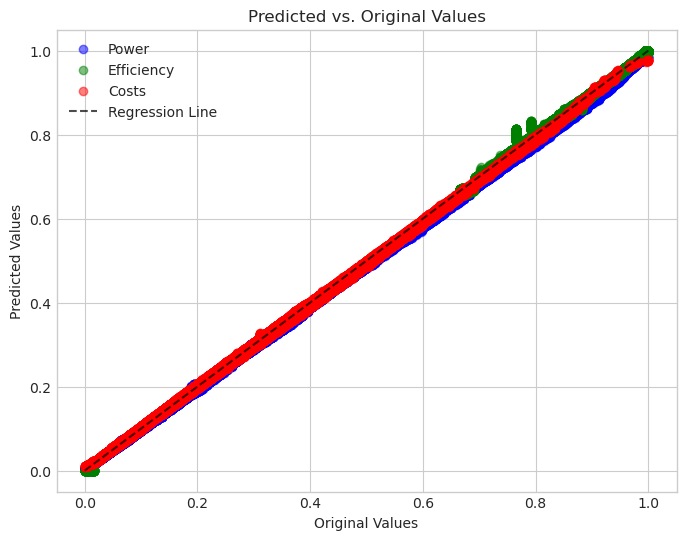

In [11]:
import numpy as np
plt.style.use('seaborn-whitegrid')
original_values = output_data[:, 0:3]

# Calculate the regression line
regression_line = np.linspace(original_values[:, 0].min(), original_values[:, 0].max(), 100)

# Perform inference to get predicted values
with torch.no_grad():
    predictions = model(input_data)

# Convert predicted and original values to NumPy arrays
predicted_values = predictions[:, 0:3]  # Assuming you want to plot the first three columns (power, efficiency, and costs)

# Plot the predicted values against the original values
plt.figure(figsize=(8, 6))
plt.scatter(original_values[:, 0], predicted_values[:, 0], label='Power', color='blue', alpha=0.5)
plt.scatter(original_values[:, 1], predicted_values[:, 1], label='Efficiency', color='green', alpha=0.5)
plt.scatter(original_values[:, 2], predicted_values[:, 2], label='Costs', color='red', alpha=0.5)

# Plot the regression line in black
plt.plot(regression_line, regression_line, color='black', linestyle='--', alpha=0.7, label='Regression Line')

plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Original Values')
plt.legend()
plt.grid(True)
plt.savefig('predicted_vs_original.png', bbox_inches='tight', dpi=500)
plt.show()

/tmp/ipykernel_578/3096037421.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


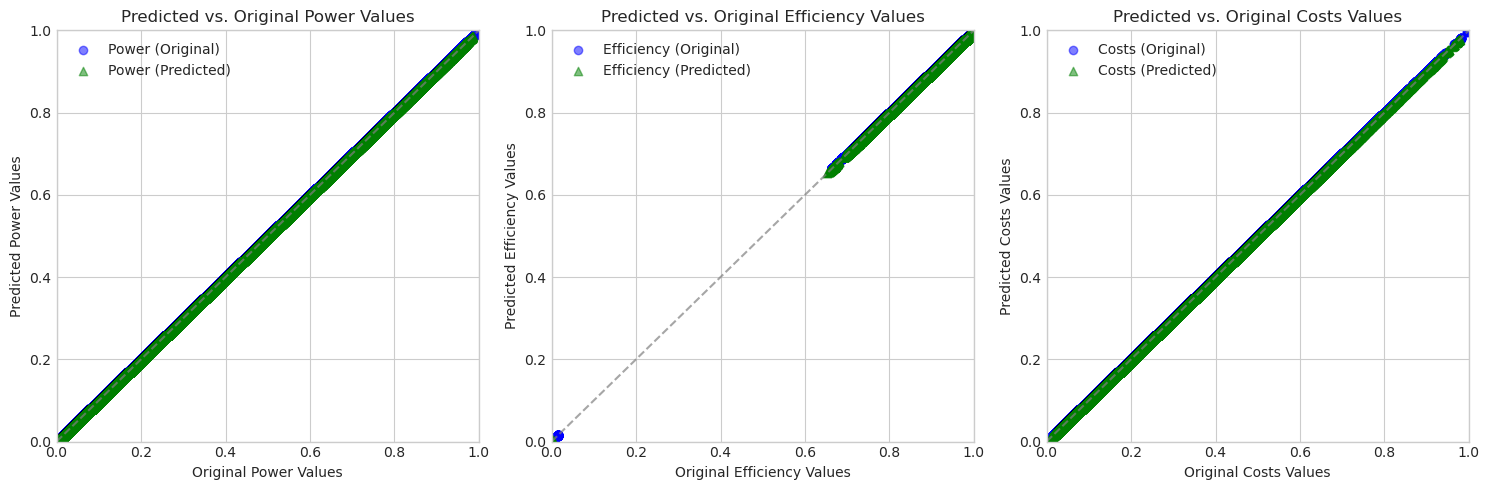

In [12]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Create subplots for each variable
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each variable
for i, variable in enumerate(['Power', 'Efficiency', 'Costs']):
    # Plot original values
    axs[i].scatter(original_values[:, i], original_values[:, i], marker='o', label=f'{variable} (Original)', color='blue', alpha=0.5)

    # Plot predicted values
    axs[i].scatter(predicted_values[:, i], predicted_values[:, i], marker='^', label=f'{variable} (Predicted)', color='green', alpha=0.5)

    # Set the same axis limits
    min_value = min(original_values[:, i].min(), predicted_values[:, i].min())
    max_value = max(original_values[:, i].max(), predicted_values[:, i].max())
    axs[i].set_xlim(min_value, max_value)
    axs[i].set_ylim(min_value, max_value)

    # Add a 1:1 line
    axs[i].plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', alpha=0.7)

    axs[i].set_xlabel(f'Original {variable} Values')
    axs[i].set_ylabel(f'Predicted {variable} Values')
    axs[i].set_title(f'Predicted vs. Original {variable} Values')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.savefig('Regression_lines_overview_1', bbox_inches='tight', dpi=500)
plt.show()


/tmp/ipykernel_578/1460440751.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


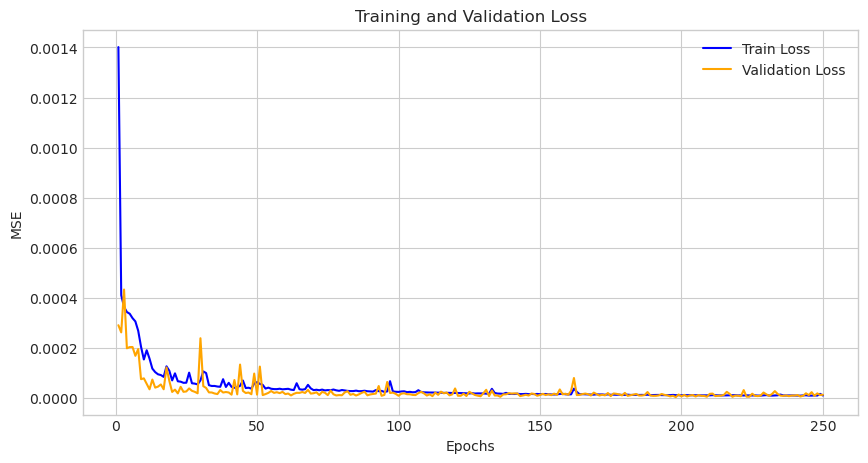

In [13]:
import matplotlib.pyplot as plt

# Assuming you have two lists train_losses and val_losses containing the loss values
plt.style.use('seaborn-whitegrid')
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss',  color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss',  color='orange')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('MSE_loss_1', bbox_inches='tight', dpi=500)
# Display the plot
plt.show()


/tmp/ipykernel_578/2660696234.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_578/2660696234.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{round(y, 5)}' for y in yticks])


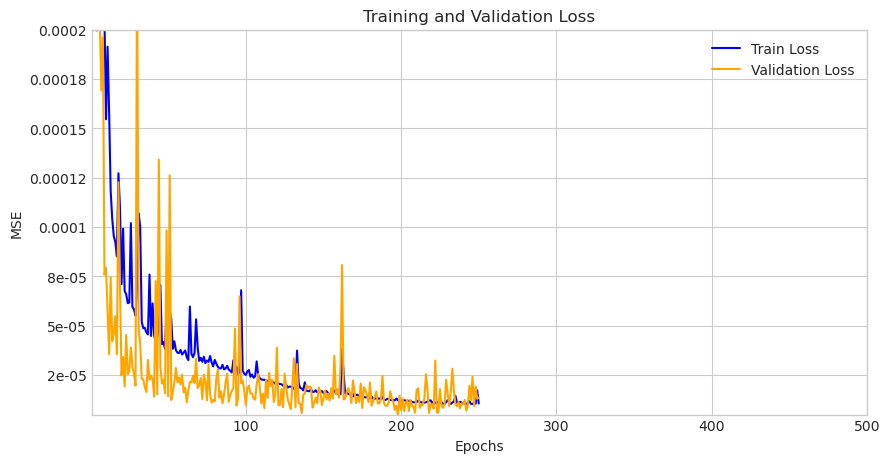

In [14]:
import matplotlib.pyplot as plt

# Assuming you have two lists train_losses and val_losses containing the loss values
plt.style.use('seaborn-whitegrid')

# Define the range you want to zoom in on
zoom_start = 1  # Starting epoch
zoom_end = 500   # Ending epoch

# Define the y-axis range you want to focus on
y_min = 0.000005   # Minimum y-value
y_max = 0.0002    # Maximum y-value

# Plotting the training and validation losses
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the training loss with blue color
ax.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')

# Plot the validation loss with orange color
ax.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')

# Adding labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')
ax.legend()

# Set the x-axis limit to zoom in
ax.set_xlim(zoom_start, zoom_end)

# Set the y-axis limit to focus on the specific range
ax.set_ylim(y_min, y_max)

# Display the exact y-axis values
yticks = ax.get_yticks()
ax.set_yticklabels([f'{round(y, 5)}' for y in yticks])
plt.savefig('MSE_loss_zoomed_1', bbox_inches='tight', dpi=500)
# Display the plot
plt.show()


/tmp/ipykernel_578/2730375109.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


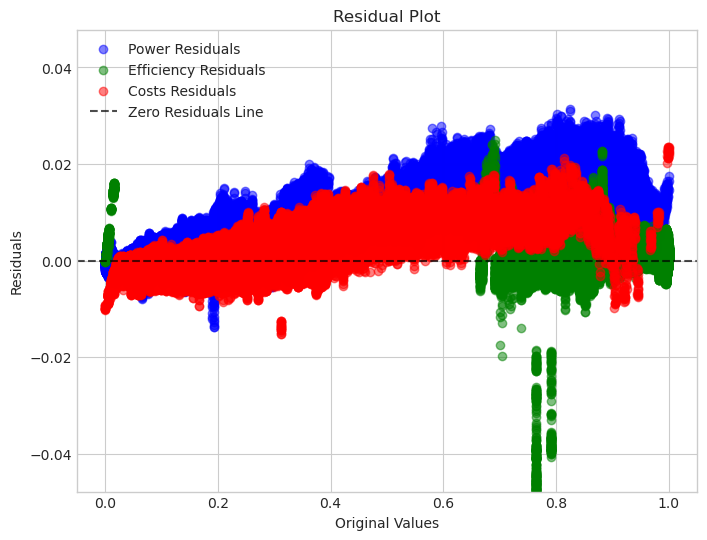

In [15]:
# Calculate residuals
residuals = original_values - predicted_values

# Set plot style and colors
plt.style.use('seaborn-whitegrid')
colors = ['blue', 'green', 'red']  # Define colors for each output

# Create the figure and axis
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot residuals for each output
for i, label in enumerate(['Power', 'Efficiency', 'Costs']):
    plt.scatter(original_values[:, i], residuals[:, i], label=f'{label} Residuals', color=colors[i], alpha=0.5)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Zero Residuals Line')

# Set axis labels and title
plt.xlabel('Original Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Set legend
plt.legend()

# Adjust plot limits for better visualization (optional)
plt.ylim([-max(abs(residuals.flatten())), max(abs(residuals.flatten()))])

# Add a grid
plt.grid(True)
plt.savefig('Residual_line_1', bbox_inches='tight', dpi=500)
# Show the plot
plt.show()
